In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import xarray as xr
import arviz as az
from scipy import stats as stats
from matplotlib import pyplot as plt

from src.utils import basic as utils

# Linear Regression & Drawing Inference

- Can be used to approximate most anything, even nonlinear phenomena (e.g. GLMs)
- We need to incorporate causal thinking into
    - How we compose statistical models
    - Process and interpret results

# Categories
- non-continuous causes
- discrete, unordered types
- stratifying by category: fit a separate regression to each

#### Howell Dataset

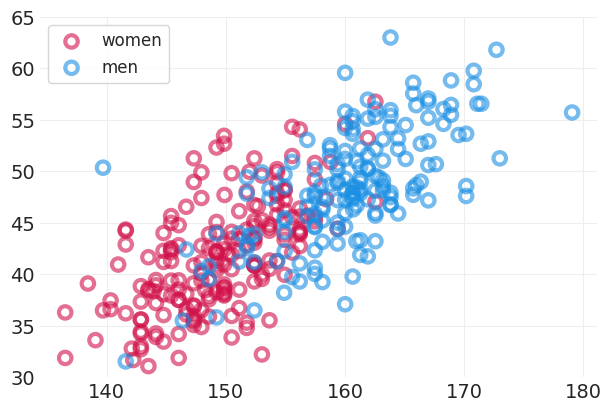

In [4]:
HOWELL = utils.load_data("Howell1")

# Adult data
ADULT_HOWELL = HOWELL[HOWELL.age >= 18]

# Splitting by Sex 
SEX = ['women', 'men']

plt.subplots(figsize=(6,4))
for ii, label in enumerate(SEX):
    utils.plot_scatter(
        ADULT_HOWELL[ADULT_HOWELL.male==ii].height,
        ADULT_HOWELL[ADULT_HOWELL.male==ii].weight,
        color=f"C{ii}",
        label=label
    )
plt.ylim([30, 65])
plt.legend()    


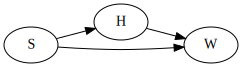

In [5]:
# Draw the mediation graph
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
    ],
    graph_direction="LR",
)
    

## Think scientifically first

- How are height, weight, and sex **causally** related?
- How are height, weight, and sex **statistically** related?

### The causes aren't in the data

Height should affect weight, not vice versa
- ✅ $H \rightarrow W$
- ❌ $H \leftarrow W$

Sex should affect height, not vice versa
- ❌ $H \rightarrow S$
- ✅ $H \leftarrow S$

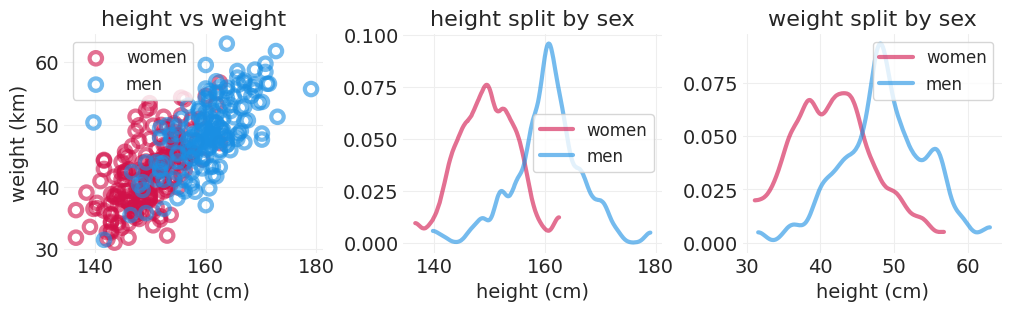

In [6]:
# Split height by the Sex Category
def plot_height_weight_distributions(data):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    plt.sca(axs[0])

    for ii, label in enumerate(SEX):
        utils.plot_scatter(
            data[data.male == ii].height,
            data[data.male == ii].weight,
            color=f"C{ii}",
            label=label,
        )
    plt.xlabel("height (cm)")
    plt.ylabel("weight (km)")
    plt.legend()
    plt.title("height vs weight")
    
    for vv, var in enumerate(['height', 'weight']):
        plt.sca(axs[vv+1])
        for ii in range(2):
            az.plot_dist(
                data.loc[data.male == ii, var].values,
                color=f"C{ii}",
                label=SEX[ii],
                bw=1,
                plot_kwargs=dict(linewidth=3, alpha=.6),
            )
        plt.title(f"{var} split by sex")
        plt.xlabel("height (cm)")
        plt.legend();
        
plot_height_weight_distributions(ADULT_HOWELL)

Causal graph defines a set of functional relationships

$$
\begin{align*}
H &= f_H(S) \\
W &= f_W(H, S)
\end{align*}
$$

Could also include unobservable causal influences (see below graph):

$$
\begin{align*}
H &= f_H(S, U) \\
W &= f_W(H, S, V) \\
S &= f_S(T)
\end{align*}
$$

> Note: we use $T$ as an unobserved variable, rather than $W$ to avoid replication in the lecture.

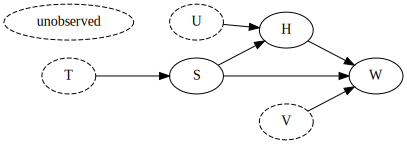

In [14]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed"},
        "U": {"style": "dashed"},
        "V": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR",
)
    

### Synthetic people

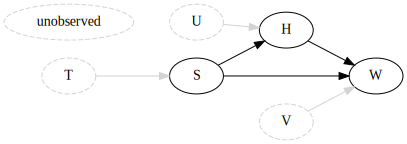

In [8]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W"),
        ("V", "W"),
        ("U", "H"),
        ("T", "S")
    ],
    node_props={
        "T": {"style": "dashed", "color": "lightgray"},
        "U": {"style": "dashed", "color": "lightgray"},
        "V": {"style": "dashed", "color": "lightgray"},
        "unobserved": {"style": "dashed", "color": "lightgray"}
    },
    edge_props={
        ("T", "S"): {"color": "lightgray"},
        ("U", "H"): {"color": "lightgray"},
        ("V", "W"): {"color": "lightgray"}
    },
    graph_direction="LR"
)

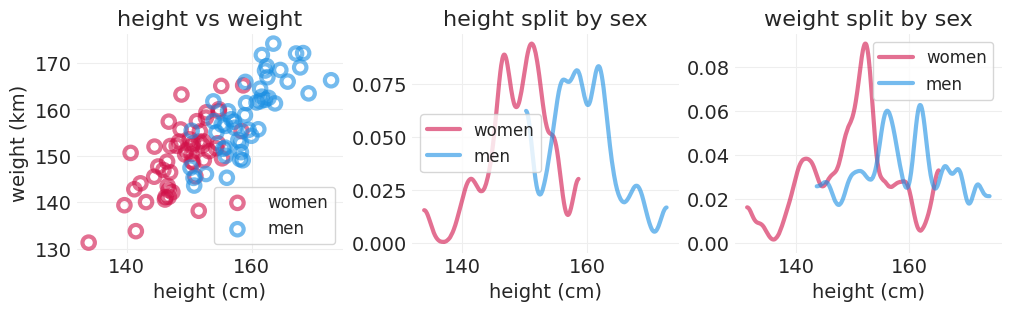

In [13]:
def simulate_sex_height_weight(
    S: np.ndarray,
    beta: np.ndarray = np.array([1, 1]),
    alpha: np.ndarray = np.array([0, 0]),
) -> np.ndarray:
    """
    Generative model for the effect of sex on height and weight.
    S: variable for sex indication (0: female; 1: male)
    beta: slope coefficient for each sex
    alpha: intercept for each sex
    """
    
    N = len(S)
    H = np.where(S, 160, 150) + stats.norm(0, 5).rvs(N)
    W = alpha[S] + beta[S] * H + stats.norm(0, 5).rvs(N)
    
    return pd.DataFrame({"height": H, "weight": W, "male": S})

synthetic_sex = stats.bernoulli(0.5).rvs(100).astype(int)
synthetic_people = simulate_sex_height_weight(S=synthetic_sex)
plot_height_weight_distributions(synthetic_people)


### Think scientifically first

Different causal questions require different statistical models:

- Q: Causal effect of H on W?
- Q: (Total) Causal effect of S on W?
- Q: *Direct* Causal effect of S on W?

Answering the last two questions requires different statistical models, but both will need stratification by S

### From estimand to estimate

#### Causal effect of H on W

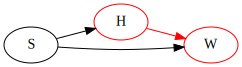

In [15]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "H": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("H", "W"): {"color": "red"},
    },
    graph_direction="LR"
)

#### **Total** Causal effect of S on W

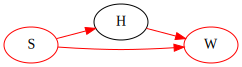

In [16]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

#### **Direct** Causal effect of S on W

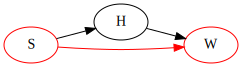

In [17]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "red"},
        "W": {"color": "red"}
    },
    edge_props={
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

**Stratify by S**: recover a different estimate for each value that $S$ can take

## Drawing the Causal Owl 🦉


Implement Categories via **Indicator Variables**

- generalizes code: can extend to any number of categories
- better for prior specification
- facilitates multi-level model specification

For categories $C = [C_1, C_2, ... C_D]$

$$
\begin{align*}
\alpha &= [\alpha_1, \alpha_2, ... \alpha_D] \\
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{C[i]}
\end{align*}
$$

For sex $S\in \{M, F\}$, we can model sex-specific  weight weight $W$ as

$$
\begin{align*}
W_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{S[i]} \\
\alpha &= [\alpha_F, \alpha_M] \\
\alpha_j &\sim \text{Normal}(60, 10) \\
\sigma &\sim \text{Uniform}(0, 10)
\end{align*}
$$




## Testing

### Total Causal Effect of Sex on Weight

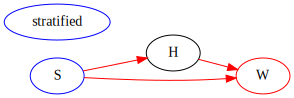

In [18]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "blue"},
        "W": {"color": "red"},
        "stratified": {"color": "blue"}
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "W"): {"color": "red"},
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

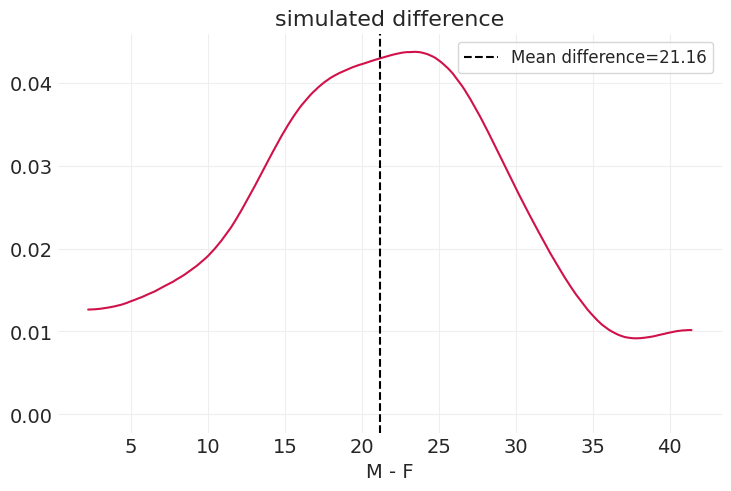

In [19]:
np.random.seed(12345)
n_simulations = 100
simulated_females = simulate_sex_height_weight(
    S=np.zeros(n_simulations).astype(int),
    beta=np.array((0.5, 0.6))
)

simulated_males = simulate_sex_height_weight(
    S=np.ones(n_simulations).astype(int),
    beta=np.array((0.5, 0.6))
)

simulated_delta = simulated_males - simulated_females
mean_simualted_delta = simulated_delta.mean()
az.plot_dist(simulated_delta['weight'].values)
plt.axvline(
    mean_simualted_delta['weight'],
    linestyle='--',
    color='k',
    label="Mean difference" + f"={mean_simualted_delta['weight']:1.2f}"
)
plt.xlabel("M - F")
plt.legend()
plt.title("simulated difference");

### Run estimating model on the synthetic sample

(1) Total Effect Model

In [20]:
def fit_total_effect_model(data):
    sex_indicator, sex = pd.factorize(["M" if s else "F" for s in data["male"].values])
    
    with pm.Model(coords={"sex": sex}) as model:
        # Data
        S = pm.MutableData("S", sex_indicator)
        
        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="sex")
        
        # Likelihood
        mu = alpha[S]
        pm.Normal("W_obs", mu, sigma, observed=data["weight"].values)
        
        idata = pm.sample()
        
    return model, idata

# Concatenate the simulations and code sex
simulated_people = pd.concat([simulated_females, simulated_males])
simulated_total_effect_model, simulated_total_effect_idata = fit_total_effect_model(simulated_people)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [22]:
simulated_summary = az.summary(simulated_total_effect_idata, var_names=["alpha", "sigma"])
simulated_delta = (simulated_summary.iloc[1] - simulated_summary.iloc[0])['mean']
print(f"Simulated delta: {simulated_delta:1.2f}")

simulated_summary

Simulated delta: 21.07


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[F],74.859,0.601,73.740,75.967,0.009,0.006,4665.0,2997.0,1.0
alpha[M],95.933,0.584,94.833,96.992,0.008,0.005,5848.0,3083.0,1.0
sigma,5.912,0.296,5.354,6.448,0.004,0.003,4629.0,2771.0,1.0


Simulated Delta is very close to inferred data

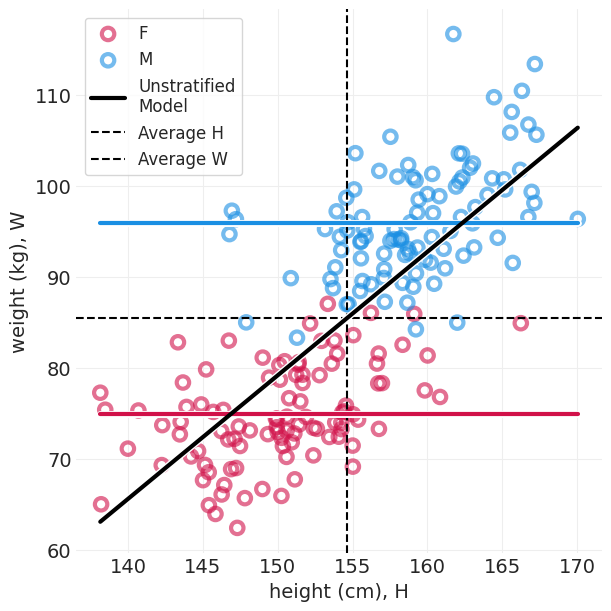

In [34]:
def plot_posterior_lines(data, idata, centered=False):
    plt.subplots(figsize=(6, 6))
    
    min_height = data['height'].min()
    max_height = data['height'].max()
    xs = np.linspace(min_height, max_height, 10)
    for ii, s in enumerate(['F', 'M']):
        sex_idx = data.male == ii
        utils.plot_scatter(
            xs=data[sex_idx].height,
            ys=data[sex_idx].weight,
            color=f"C{ii}",
            label=s,
        )
        
        posterior_mean = idata.posterior.sel(sex=s).mean(dim=('chain', 'draw'))
        posterior_mean_alpha = posterior_mean['alpha'].values
        posterior_mean_beta = getattr(posterior_mean, 'beta', pd.Series([0])).values
        
        if centered:
            pred_x = xs - data.height.mean()
        else:
            pred_x = xs
            
        ys = posterior_mean_alpha + posterior_mean_beta * pred_x
        utils.plot_line(xs, ys, color=f"C{ii}", label=None)
        
    # Model fit to both sexes simultaneously
    global_model = smf.ols("weight ~ height", data=data).fit()
    ys = global_model.params.Intercept + global_model.params.height * xs
    utils.plot_line(xs, ys, color="k", label='Unstratified\nModel')
    
    plt.axvline(
        data.height.mean(),
        linestyle='--',
        color='k',
        label="Average H"
    )
    plt.axhline(
        data.weight.mean(),
        linestyle='--',
        color='k',
        label="Average W"
    )
        
    plt.legend()
    plt.xlabel("height (cm), H")
    plt.ylabel("weight (kg), W");
        
plot_posterior_lines(simulated_people, simulated_total_effect_idata, centered=True)


In [47]:
posterior = simulated_total_effect_idata.posterior

(4, 1000, 2)

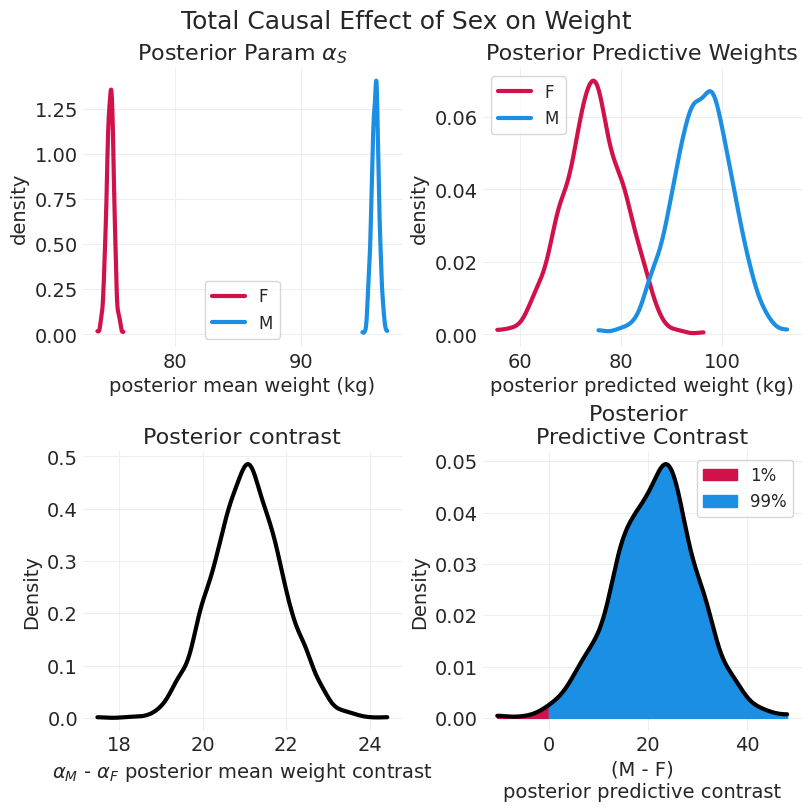

In [59]:
# Helper function for plotting
def plot_model_posterior(iData, effect_type: str = 'Total'):
    np.random.seed(123)
    sex = ['F', 'M']
    posterior = iData.posterior
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    
    # Posterior mean
    plt.sca(axs[0, 0])
    for ii, s in enumerate(sex):
        posterior_mean = posterior["alpha"].sel(sex=s).mean(dim='chain') # taking mean across chains for each sex
        az.plot_dist(
            posterior_mean,
            label=s,
            color=f"C{ii}",
            plot_kwargs=dict(linewidth=3),
        )
        
    plt.xlabel("posterior mean weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior Param $\\alpha_S$")
        
    # Posterior predictive
    plt.sca(axs[0, 1])
    posterior_prediction_std = posterior["sigma"].mean(dim='chain')
    posterior_prediction = {}
    for ii, s in enumerate(sex):
        posterior_prediction_mean = posterior["alpha"].sel(sex=s).mean(dim='chain')
        posterior_prediction[s] = stats.norm.rvs(posterior_prediction_mean, posterior_prediction_std)
        az.plot_dist(
            posterior_prediction[s],
            label=s,
            color=f"C{ii}",
            plot_kwargs=dict(linewidth=3),
        )
        
    plt.xlabel("posterior predicted weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior Predictive Weights")
    
    # Plot contrasts
    ## Posterior contrast
    plt.sca(axs[1, 0])
    posterior_contrast = posterior["alpha"].sel(sex='M') - posterior["alpha"].sel(sex='F')
    az.plot_dist(posterior_contrast, color='k', plot_kwargs=dict(linewidth=3))
    plt.xlabel("$\\alpha_M$ - $\\alpha_F$ posterior mean weight contrast")
    plt.ylabel("Density")
    plt.title("Posterior contrast")
    
    ## Posterior predictive contrast
    plt.sca(axs[1, 1])
    posterior_prediction_contrast = posterior_prediction['M'] - posterior_prediction['F']
    n_draws = len(posterior_prediction_contrast)
    kde_ax = az.plot_dist(posterior_prediction_contrast, color='k', plot_kwargs=dict(linewidth=3))
    
    # Shade under the posterior predictive contrast
    kde_x, kde_y = kde_ax.lines[0].get_data()
    
    # Proportion of PPD contrast below 0
    neg_idx = kde_x < 0
    prob_neg = 100 * np.sum(posterior_prediction_contrast < 0) / n_draws
    plt.fill_between(
        x=kde_x[neg_idx],
        y1=np.zeros(sum(neg_idx)),
        y2=kde_y[neg_idx],
        color='C0',
        label=f"{prob_neg:1.0f}%"
    )
    
    # Proportion of PPD contrast above 0
    pos_idx = kde_x > 0
    prob_pos = 100 * np.sum(posterior_prediction_contrast > 0) / n_draws
    plt.fill_between(
        x=kde_x[pos_idx],
        y1=np.zeros(sum(pos_idx)),
        y2=kde_y[pos_idx],
        color='C1',
        label=f"{prob_pos:1.0f}%"
    )
    
    plt.xlabel("(M - F)\nposterior predictive contrast")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Posterior \nPredictive Contrast");
    plt.suptitle(f"{effect_type} Causal Effect of Sex on Weight", fontsize=18)
    
    
    
plot_model_posterior(simulated_total_effect_idata)

## Analyze real sample

In [55]:
adult_howell_total_effect_model, adult_howell_total_effect_idata = fit_total_effect_model(ADULT_HOWELL)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [56]:
adult_howell_total_effect_summary = az.summary(adult_howell_total_effect_idata, var_names=['alpha'])
adult_howell_total_effect_delta = (adult_howell_total_effect_summary.iloc[1] - adult_howell_total_effect_summary.iloc[0])['mean']
print(f"Delta in average sex-specific weight: {adult_howell_total_effect_delta:1.2f}")

adult_howell_summary = az.summary(adult_howell_total_effect_idata)
adult_howell_summary

Delta in average sex-specific weight: -6.76


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[M],48.612,0.430,47.832,49.412,0.006,0.004,6012.0,2833.0,1.0
alpha[F],41.851,0.407,41.089,42.613,0.005,0.004,6224.0,3244.0,1.0
sigma,5.525,0.207,5.157,5.927,0.003,0.002,5783.0,2946.0,1.0


### Always be contrasting
- need compare the **contrast** between categories 
- **never valid to calculate overlap** in distributions
  - this means **no comparing confidence intervals for p-values**
- Compute the difference of distributions -- the **contrast distribution**

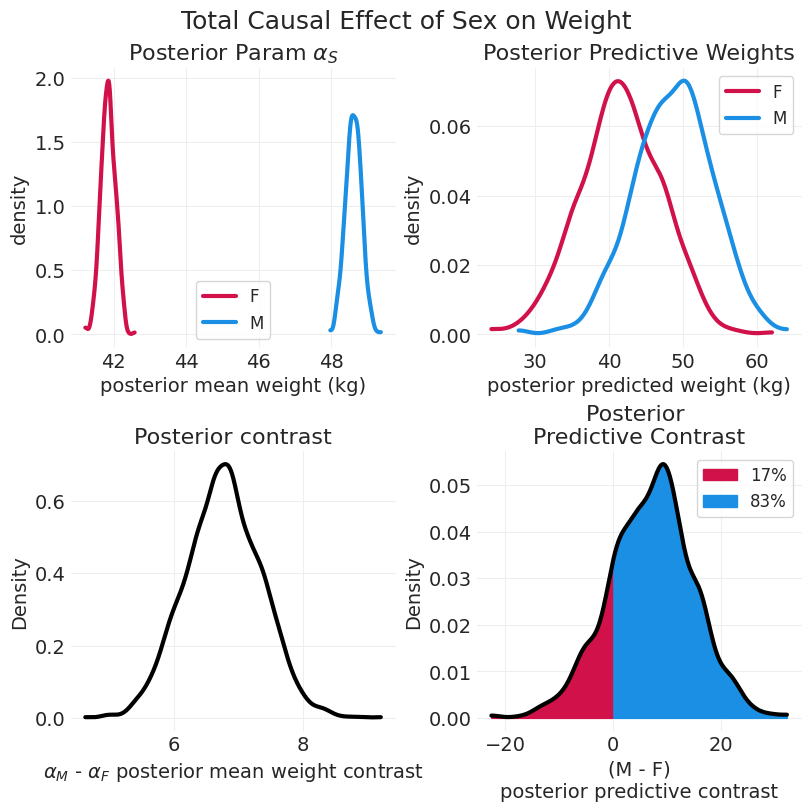

In [61]:
plot_model_posterior(adult_howell_total_effect_idata)

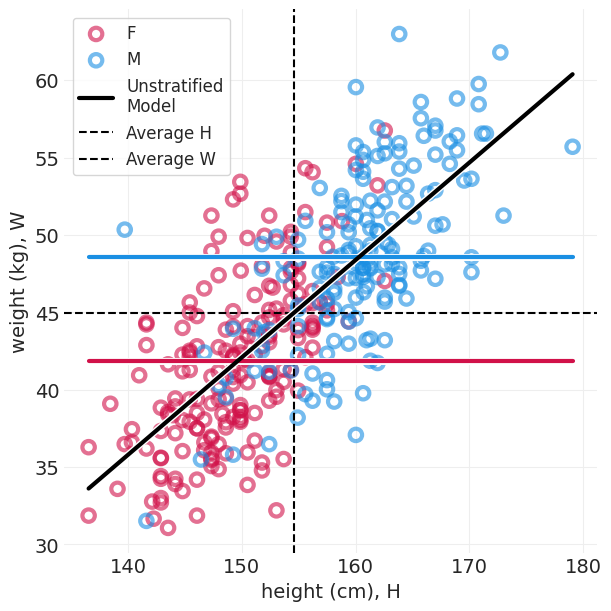

In [63]:
plot_posterior_lines(ADULT_HOWELL, adult_howell_total_effect_idata, True)

### **Direct** causal effect of $S$ on $W$?
We need another model/estimator for this estimand

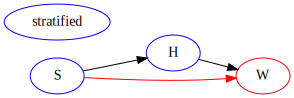

In [64]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "W"),
        ("S", "H")
    ],
    node_props={
        "S": {"color": "blue"},
        "W": {"color": "red"},
        "H": {"color": "blue"},
        "stratified": {"color": "blue"}
    },
    edge_props={
        ("S", "W"): {"color": "red"}
    },
    graph_direction="LR"
)

$$
\begin{align*}
W_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{S[i]} + \beta_{S[i]} (H_i - \bar H)
\end{align*}
$$

Where we've **centered the height**, meaning that 
- $\beta$ scales the difference of $H_i$ from the average height
- $\alpha$ is the weight when a person is the average height
- Global model fit to all data lies at the intersection of global average height and weight

### Simulate some more people

In [68]:
ALPHA=0.9
np.random.seed(1234)
n_synthetic_people = 200

synthetic_sex = stats.bernoulli.rvs(p=.5, size=n_synthetic_people)
synthetic_people = simulate_sex_height_weight(
    S=synthetic_sex,
    beta=np.array([0.5, 0.5]), # Same relationship between height & weight
    alpha=np.array([0.0, 10])  # 10kg "boost for Males"
)

### Analyze the synthetic people

In [77]:
def fit_direct_effect_weight_model(data):
    
    sex_indicator, sex = pd.factorize(["M" if s else "F" for s in data["male"].values])
    
    with pm.Model(coords={"sex": sex}) as model:
        # Data
        S = pm.MutableData("S", sex_indicator, dims="obs_ids")
        H = pm.MutableData("H", data["height"].values, dims="obs_ids")
        Hbar = pm.MutableData("Hbar", data["height"].mean())
        
        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="sex")
        beta = pm.Uniform("beta", 0, 1, dims="sex") # positive slope only
        
        # Likelihood
        mu = alpha[S] + beta[S] * (H - Hbar)
        pm.Normal("W_obs", mu, sigma, observed=data["weight"].values, dims="obs_ids")
        
        idata = pm.sample()
        
    return model, idata

In [80]:
direct_effect_simulated_model, direct_effect_simulated_inference = fit_direct_effect_weight_model(simulated_people)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


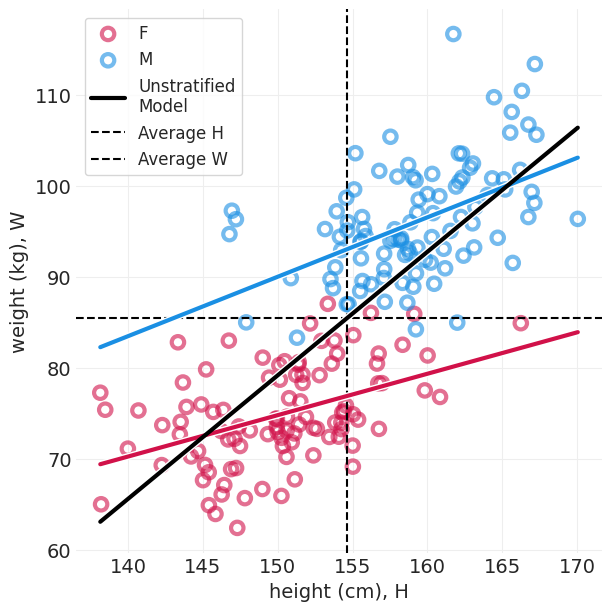

In [81]:
plot_posterior_lines(simulated_people, direct_effect_simulated_inference, centered=True)

- **Indirect effect**: M & F have specific slopes - in this simulation, they are the same slope, thus parallel lines
- **Direct effect**: There will be a delta, no matter the slope. -- in this simulation M are always 10kg heavier, thus blue is always above red

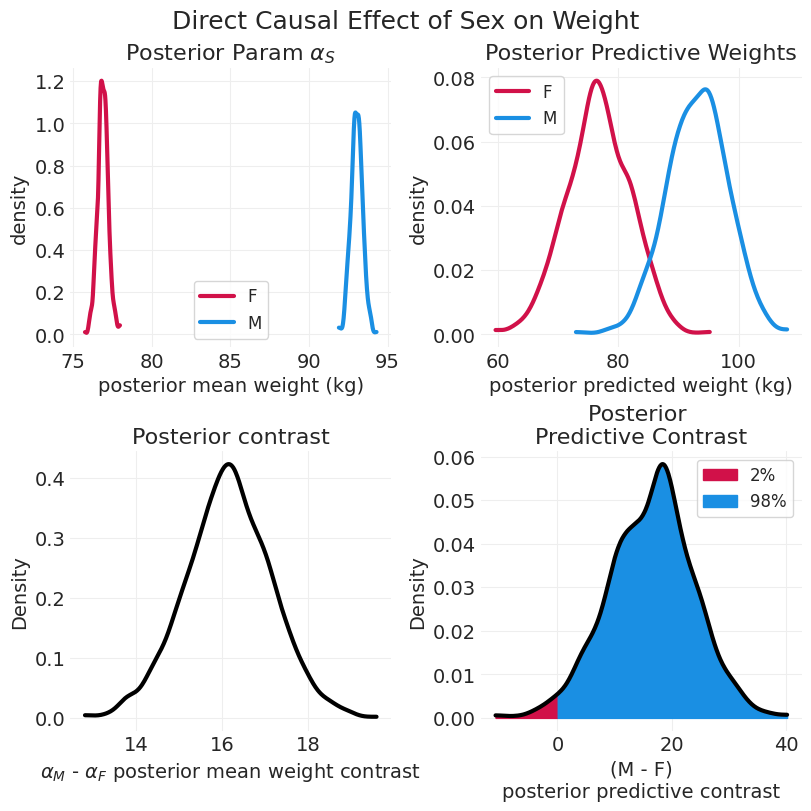

In [82]:
plot_model_posterior(direct_effect_simulated_inference, "Direct")

## Analyze the real sample

In [96]:
direct_effect_howell_model, direct_effect_howell_inference = fit_direct_effect_weight_model(ADULT_HOWELL)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


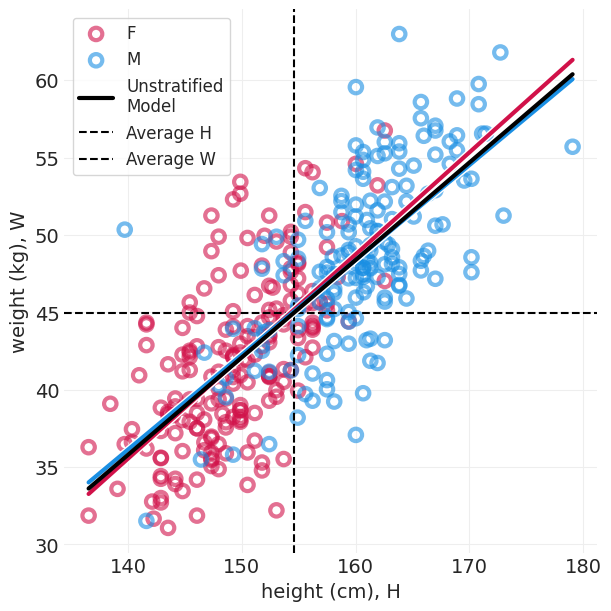

In [97]:
plot_posterior_lines(ADULT_HOWELL, direct_effect_howell_inference, True)

#### Contrasts

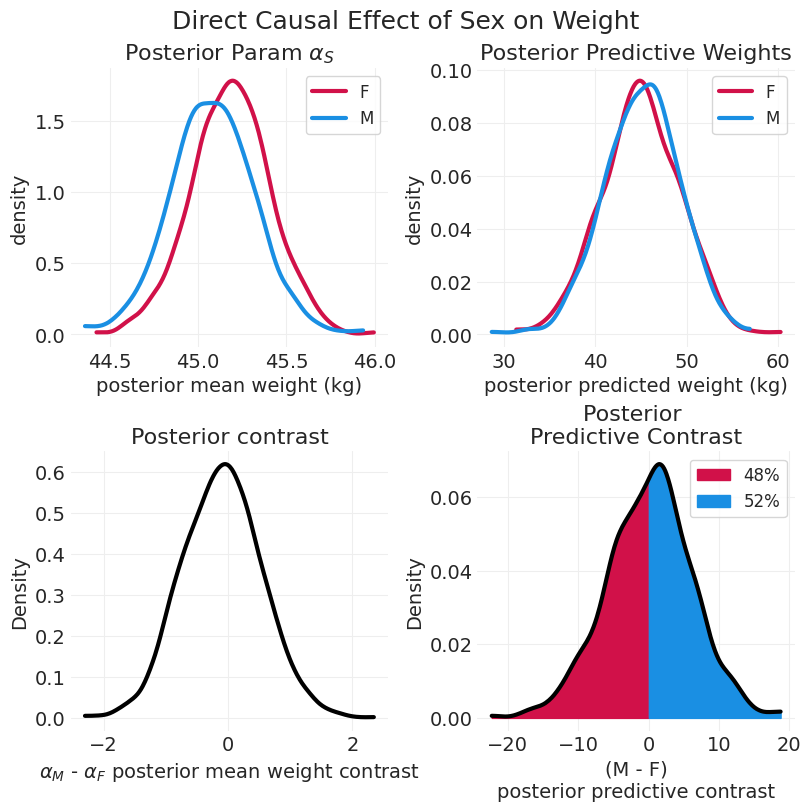

In [98]:
plot_model_posterior(direct_effect_howell_inference, "Direct")

## Contrast at each height

In [101]:
def plot_heightwise_contrast(model, inference):
    heights = np.linspace(130, 190, 100)
    ppds = {}
    for ii, s in enumerate(['F', 'M']):
        with model:
            pm.set_data(
                {
                    "S": np.ones_like(heights).astype(int) * ii,
                    "H": heights,
                    "Hbar": heights.mean()
                }
            )
            ppds[s] = pm.sample_posterior_predictive(inference, extend_inferencedata=False).posterior_predictive["W_obs"]
    
    ppd_contrasts = ppds['M'] - ppds['F']
    
    # Plot contours 
    for prob in [0.5, 0.75, .95, .99]:
        az.plot_hdi(heights, ppd_contrasts, hdi_prob=prob, fill_kwargs=dict(alpha=ALPHA))
        
    plt.axhline(0, linestyle='--', color='k')
    plt.xlabel("height, H (cm)")
    plt.ylabel("wright W contrast (M-F)")
    plt.xlim([130, 190])


Sampling: [W_obs]


Sampling: [W_obs]


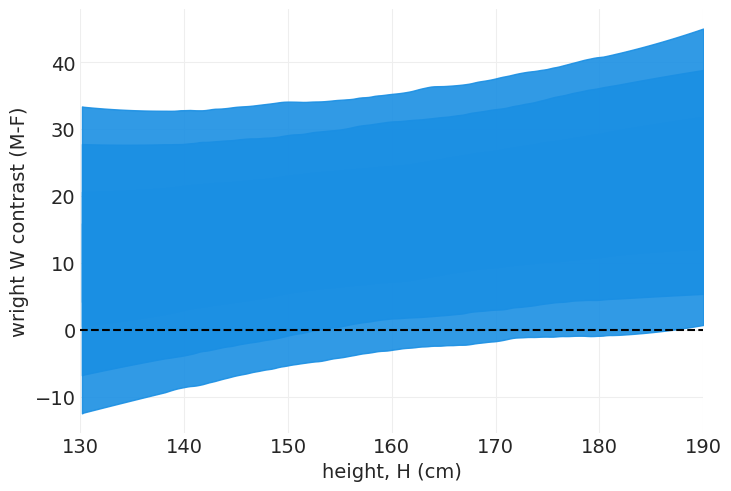

In [105]:
# Try on the simulated data
plot_heightwise_contrast(direct_effect_simulated_model, direct_effect_simulated_inference)

we can see that in the simulated data, men are consistently heavier than women, which is aligned with the simulation

Sampling: [W_obs]


Sampling: [W_obs]


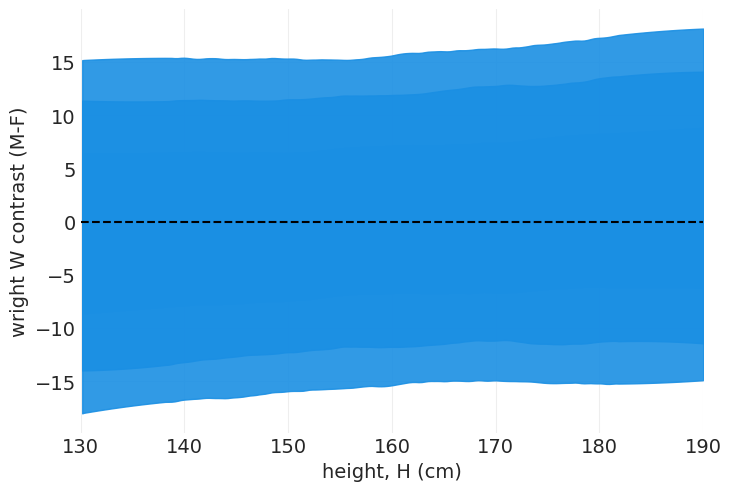

In [104]:
plot_heightwise_contrast(direct_effect_howell_model, direct_effect_howell_inference)

When stratifying by Height, we see that Sex has very little, if any causal effect on height. i.e. **a lion's share of the causal effect on weight comes via height.**

# Curves from lines
Not all relationships are linear
- e.g. in the Howell dataset, we can see that if we include all ages, the relationship between Height and Weight is nonlinear
- linear models can fit curves
- **still not a mechanistic model**

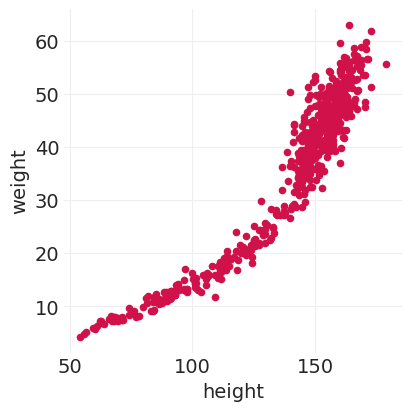

In [106]:
fig, ax = plt.subplots(figsize=(4, 4))
HOWELL.plot(x='height', y='weight', kind='scatter', ax=ax);

## Polynomial Linear Models

$$\mu_i = \alpha + \sum_i^D \beta_i x^D $$

### Issues
- symmetric -- strange edge anomolies
- global models, so no local interpolation

### Quadratic Polynomial Model

$$\mu_i = \alpha + \beta_2 x + \beta_2 x^2 $$


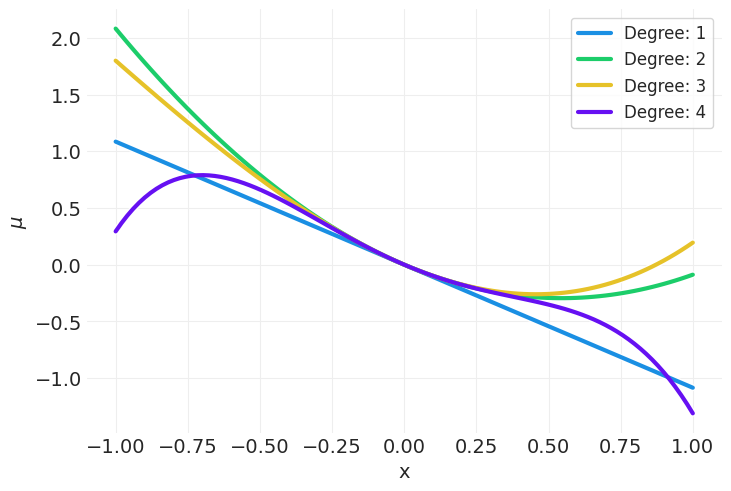

In [107]:
def plot_polynomial_sample(degree, random_seed=123):
    np.random.seed(random_seed)
    xs = np.linspace(-1, 1, 100)
    ys = 0
    for d in range(1, degree+1):
        beta_d = np.random.randn() 
        ys += beta_d * xs ** d
        
    utils.plot_line(xs, ys, color=f"C{degree}", label=f"Degree: {degree}")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("$\\mu$")
for degree in [1, 2, 3, 4]:
    plot_polynomial_sample(degree)

#### Simulate Bayesian Updating for Quadratic Polynomial Model
For the following simulation, we'll use a custom utility function `utils.simulate_2_parameter_bayesian_learning` for simulating general Bayeisan posterior update simulation. Here's the API for that function (for more details see `src/utils/basic.py`)

In [108]:
def quadratic_polynomial_model(x, beta_1, beta_2):
    return beta_1 * x + beta_2 * x ** 2

def quadratic_polynomial_regression_posterior(x_obs, y_obs, beta_1_grid, beta_2_grid, likelihood_prior_std = 1.0):
    
    beta_1_grid = beta_1_grid.ravel()
    beta_2_grid = beta_2_grid.ravel()
    
    log_prior_beta_1 = stats.norm(0, 1).logpdf(beta_1_grid)
    log_prior_beta_2 = stats.norm(0, 1).logpdf(beta_2_grid)
    
    log_likelihood = np.array(
        [
            stats.norm(
                b1 * x_obs + b2 * x_obs ** 2,
                likelihood_prior_std
            ).logpdf(y_obs) for b1, b2 in zip(beta_1_grid, beta_2_grid)
        ]
    ).sum(axis=1)

    log_posterior = log_likelihood + log_prior_beta_1 + log_prior_beta_2

    return np.exp(log_posterior - log_posterior.max())

##### Run the simulation

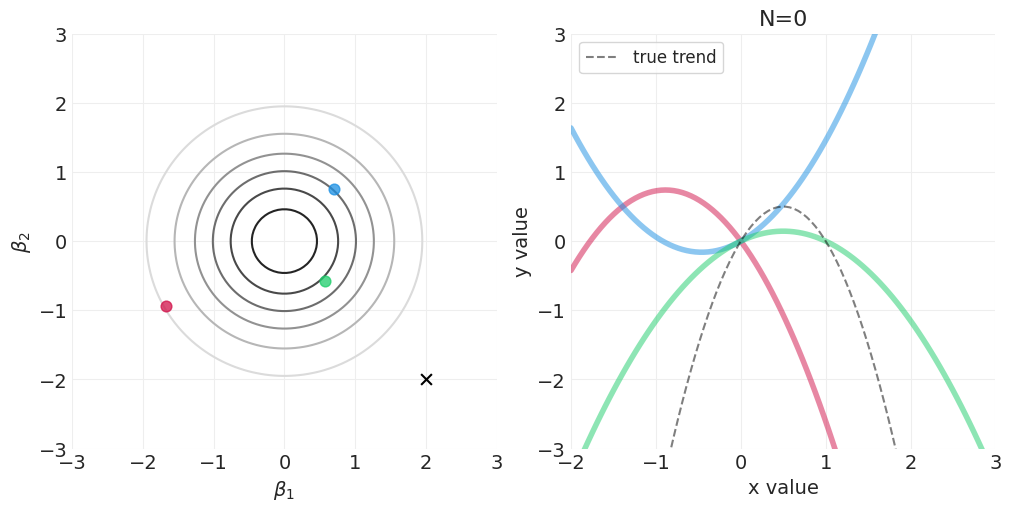

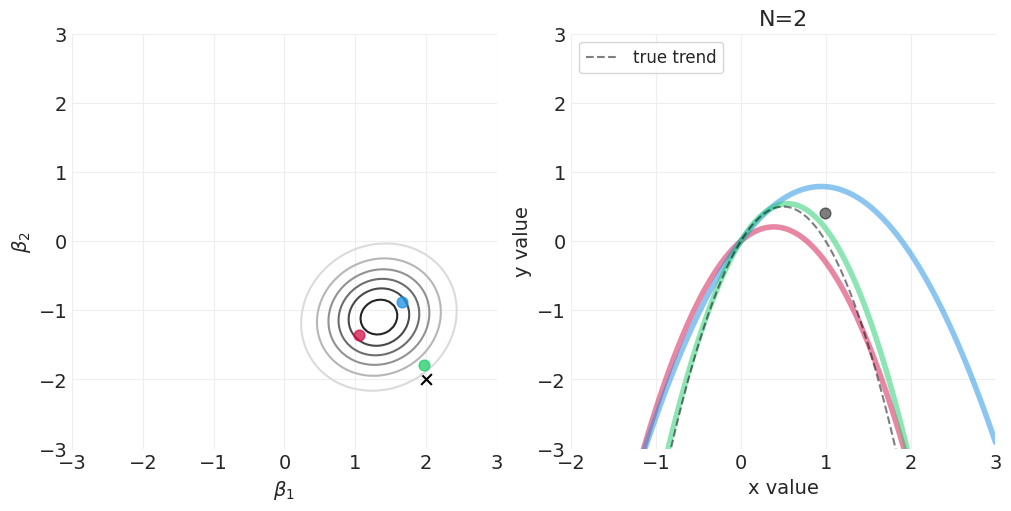

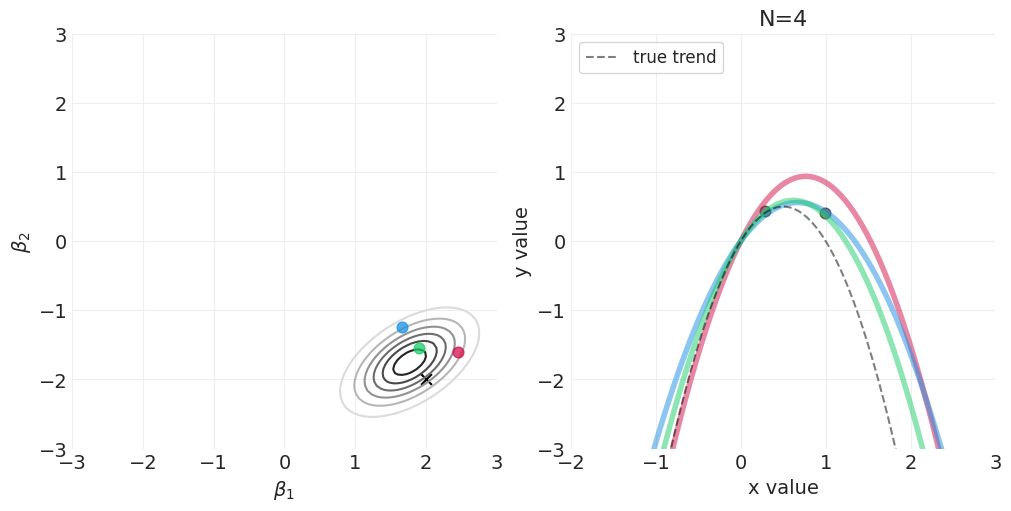

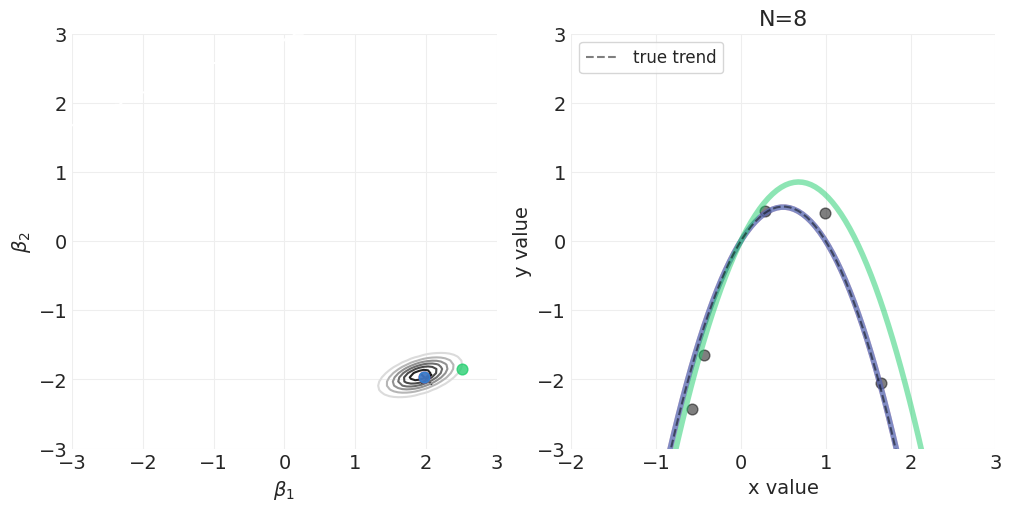

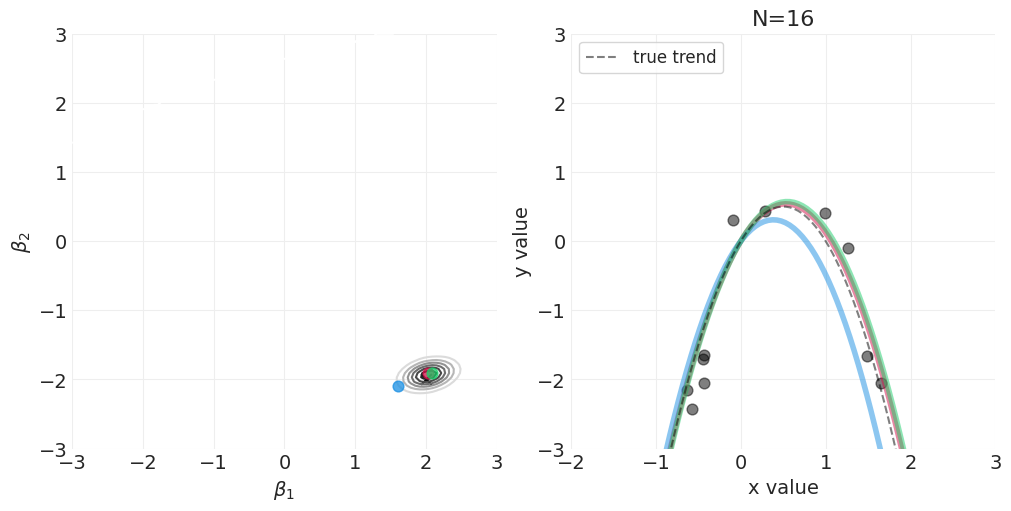

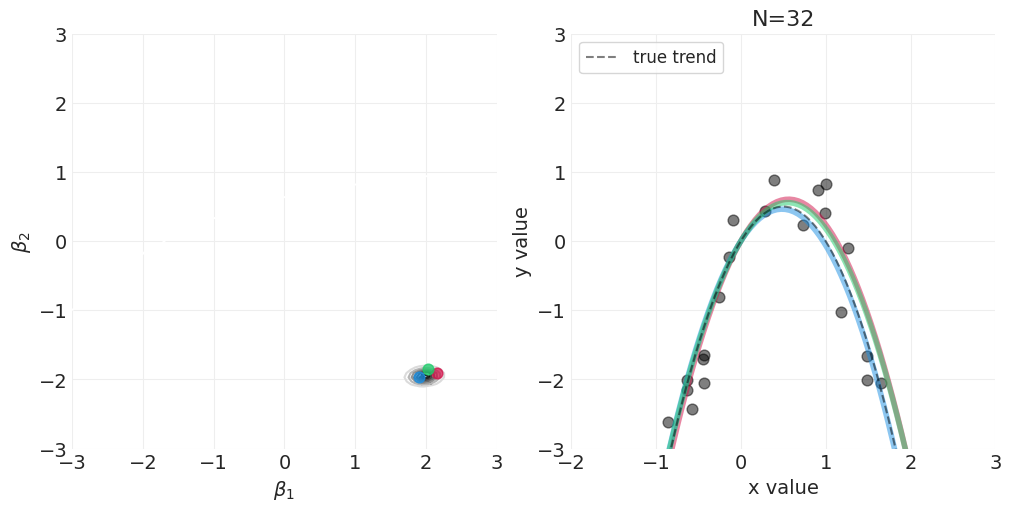

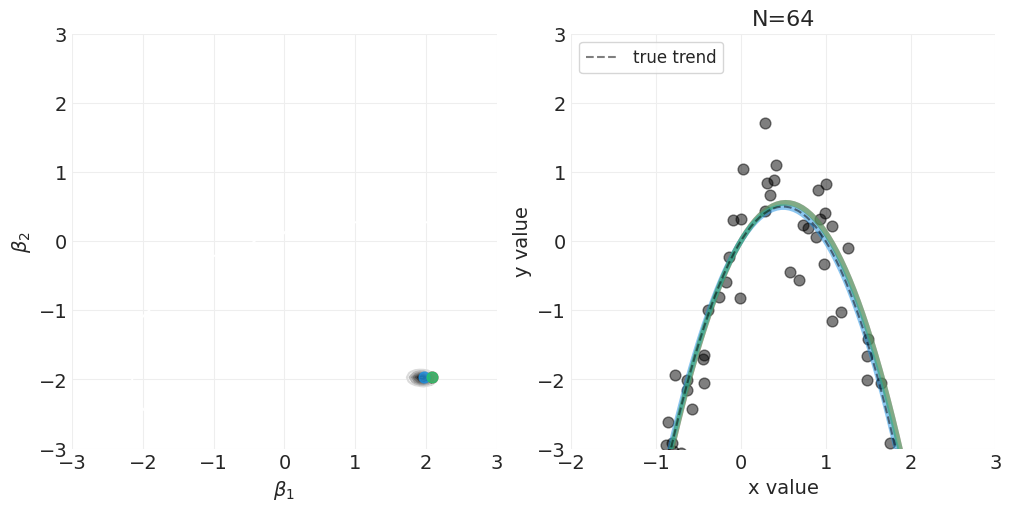

In [109]:
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 64
BETA_1 = 2
BETA_2 = -2
INTERCEPT = 0

# Generate observations
x = stats.norm().rvs(size=N_DATA_POINTS)
y = INTERCEPT + BETA_1 * x + BETA_2 * x ** 2 + stats.norm.rvs(size=N_DATA_POINTS) * .5

beta_1_grid = np.linspace(-3, 3, RESOLUTION)
beta_2_grid = np.linspace(-3, 3, RESOLUTION)

# Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64]:

    utils.simulate_2_parameter_bayesian_learning(
        x_obs=x[:n_samples],
        y_obs=y[:n_samples],
        param_a_grid=beta_1_grid,
        param_b_grid=beta_2_grid,
        true_param_a=BETA_1,
        true_param_b=BETA_2,
        model_func=quadratic_polynomial_model,
        posterior_func=quadratic_polynomial_regression_posterior,
        param_labels=['$\\beta_1$', '$\\beta_2$'],
        data_range_x=(-2, 3), data_range_y=(-3, 3)
    )

### Fitting N-th Order Polynomials to Height / Width Data

In [113]:
def fit_nth_order_polynomial(data, n=3):
    with pm.Model() as model:
        # Data
        H_std = pm.MutableData("H", utils.standardize(data.height.values), dims="obs_ids")

        # Priors        
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 0, 60)
        betas = []
        for ii in range(n):
            betas.append(pm.Normal(f"beta_{ii+1}", 0, 5))
            
        # Likelihood
        mu = alpha
        for ii, beta in enumerate(betas):
            mu += beta * H_std ** (ii + 1)
            
        mu = pm.Deterministic('mu', mu)
    
        pm.Normal("W_obs", mu, sigma, observed=data.weight.values, dims="obs_ids")
        
        inference = pm.sample(target_accept=.95)
        
    return model, inference


polynomial_models = {}
for order in [2, 4, 6]:
    polynomial_models[order] = fit_nth_order_polynomial(HOWELL, n=order)     


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_1, beta_2, beta_3, beta_4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 235 seconds.


Sampling: [W_obs]


Sampling: [W_obs]


Sampling: [W_obs]


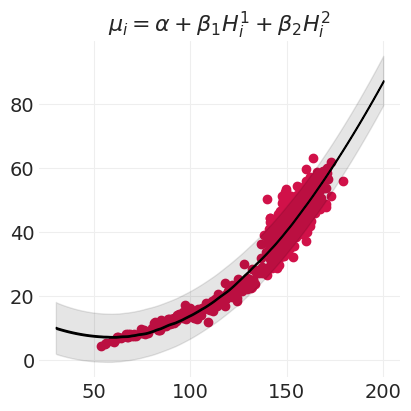

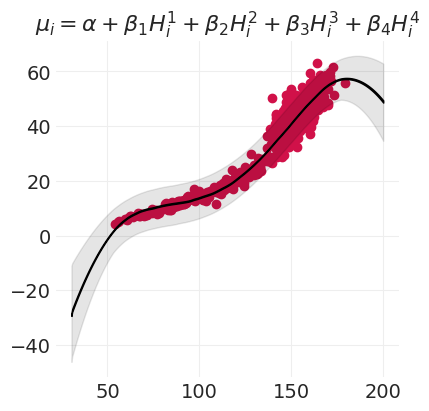

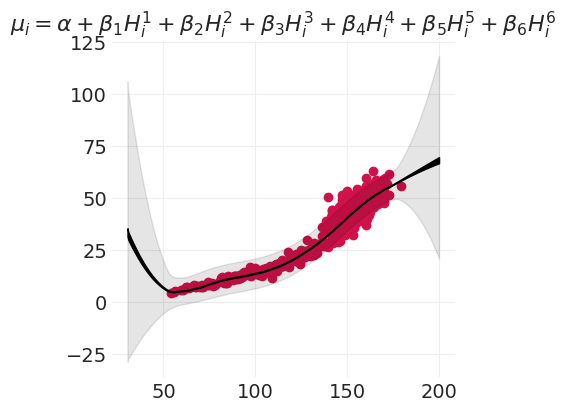

In [114]:
def plot_polynomial_model_posterior_predictive(model, inference, data, order):
    
    # Sample the posterior predictive for regions outside of the training data
    prediction_heights = np.linspace(30, 200, 100)
    with model:
        std_heights = (prediction_heights - data.height.mean()) / data.height.std()
        pm.set_data({"H": std_heights})
        ppd = pm.sample_posterior_predictive(inference, extend_inferencedata=False)
    
    plt.subplots(figsize=(4, 4))
    plt.scatter(data.height, data.weight)
    az.plot_hdi(prediction_heights, ppd.posterior_predictive['W_obs'], color='k', fill_kwargs=dict(alpha=.1))
    
    # Hack: use 5% HDI as proxy for posterior predictive mean
    az.plot_hdi(prediction_heights, ppd.posterior_predictive['W_obs'], hdi_prob=.05, color='k', fill_kwargs=dict(alpha=1))
    terms = "+".join([f"\\beta_{o} H_i^{o}" for o in range(1, order + 1)])
    plt.title(f"$\mu_i = \\alpha + {terms}$")
    
for order in [2, 4, 6]:
    model, inference = polynomial_models[order]
    plot_polynomial_model_posterior_predictive(model, inference, HOWELL, order)


### Thinking vs Fitting
- Linear models can fit anything (geocentric)
- Better off to use domain expertise to build more biologically plausible model e.g.

$$
\begin{align*}
\log W_i = \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta (H - \bar H)
\end{align*}
$$

## Splines
- "Wiggles" built from locally-fit smooth functions
- good alternative when you have little domain knowledge of the problem

$$
\mu_i = \alpha_0 + \alpha_1 B_1 + \alpha_2 B_2 + ... \alpha_S B_K
$$

where $B$ is a set of $K$ local kernel functions

## Example: Cherry Blossom Blooms

,year,doy,temp,temp_upper,temp_lower
11,812,92.0,NaN,NaN,NaN
14,815,105.0,NaN,NaN,NaN
30,831,96.0,NaN,NaN,NaN
50,851,108.0,7.38,12.1,2.66
52,853,104.0,NaN,NaN,NaN


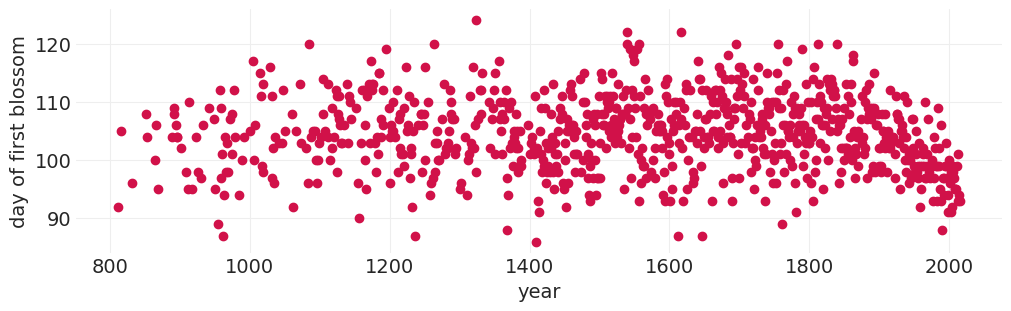

In [115]:
BLOSSOMS = utils.load_data("cherry_blossoms")
BLOSSOMS.dropna(subset=["doy"], inplace=True)
plt.subplots(figsize=(10, 3))
plt.scatter(
    x=BLOSSOMS.year,
    y=BLOSSOMS.doy
)
plt.xlabel("year")
plt.ylabel("day of first blossom")
BLOSSOMS.head()

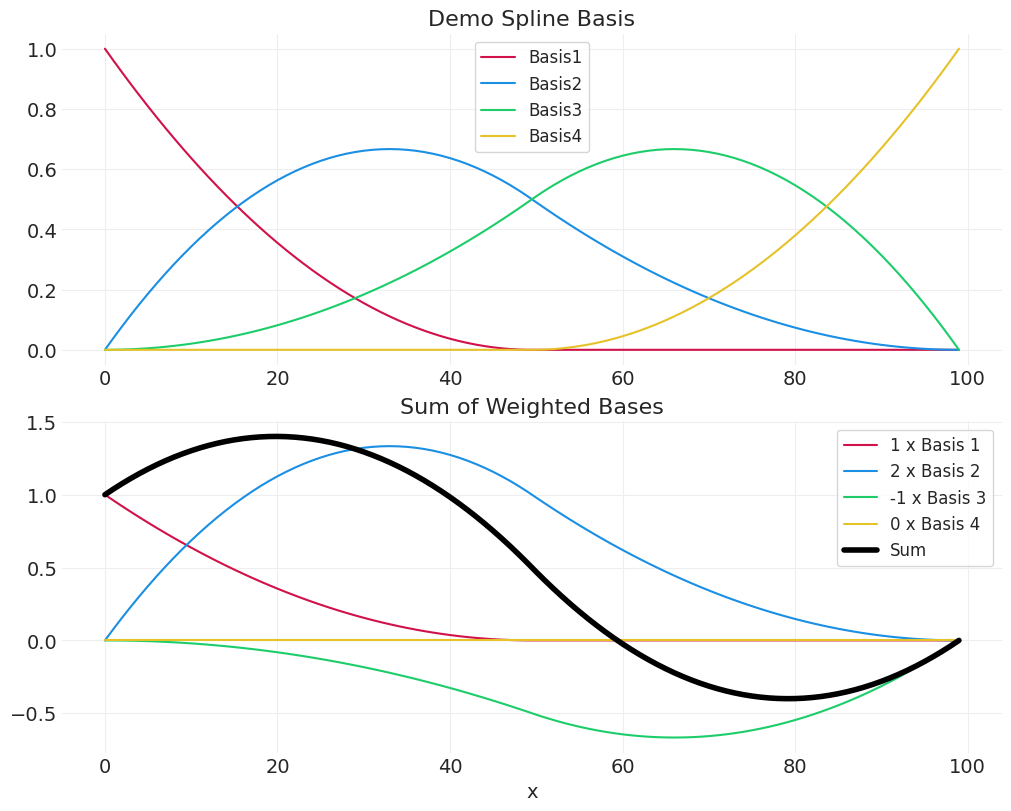

In [117]:
from patsy import dmatrix

def generate_spline_basis(data, xdim='year', degree=2, n_bases=10):
    n_knots = n_bases - 1
    knots = np.quantile(data[xdim], np.linspace(0, 1, n_knots))
    return dmatrix(
        f"bs({xdim}, knots=knots, degree={degree}, include_intercept=True) - 1",
        {xdim: data[xdim], "knots": knots[1:-1]}
    )
    
# 4 spline basis for demo
demo_data = pd.DataFrame({"x": np.arange(100)})
demo_basis = generate_spline_basis(demo_data, "x", n_bases=4)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.sca(axs[0])
for bi in range(demo_basis.shape[1]):
    plt.plot(demo_data.x, demo_basis[:, bi], color=f"C{bi}", label=f'Basis{bi+1}')
plt.legend();
plt.title("Demo Spline Basis")

# Arbitrarily-set weights for demo
basis_weights = [1, 2, -1, 0]

plt.sca(axs[1])
resulting_curve = np.zeros_like(demo_data.x)
for bi in range(demo_basis.shape[1]):
    weighted_basis = demo_basis[:, bi] * basis_weights[bi]
    resulting_curve = resulting_curve + weighted_basis
    plt.plot(demo_data.x, weighted_basis, color=f"C{bi}", label=f'{basis_weights[bi]} x Basis {bi+1}')
plt.plot(demo_data.x, resulting_curve, label='Sum', color='k', linewidth=4)
plt.xlabel("x")
plt.legend();
plt.title("Sum of Weighted Bases");

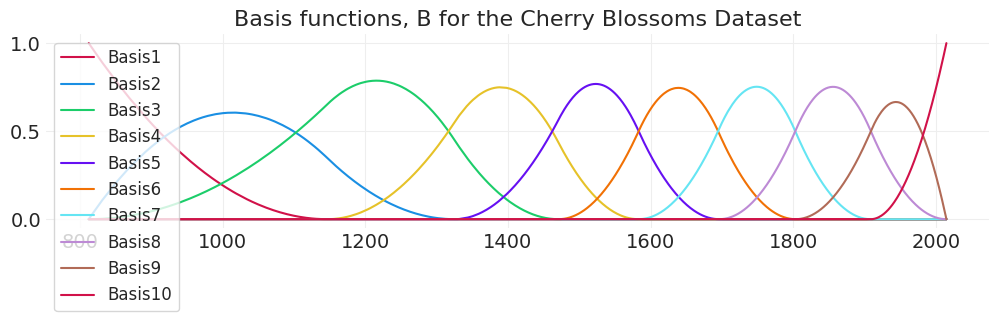

In [118]:
# 10 spline basis for modeling blossoms data
blossom_basis = generate_spline_basis(BLOSSOMS)

fig, ax = plt.subplots(figsize=(10, 3))

for bi in range(blossom_basis.shape[1]):
    ax.plot(BLOSSOMS.year, blossom_basis[:, bi], color=f"C{bi}", label=f'Basis{bi+1}')
plt.legend();
plt.title("Basis functions, B for the Cherry Blossoms Dataset");

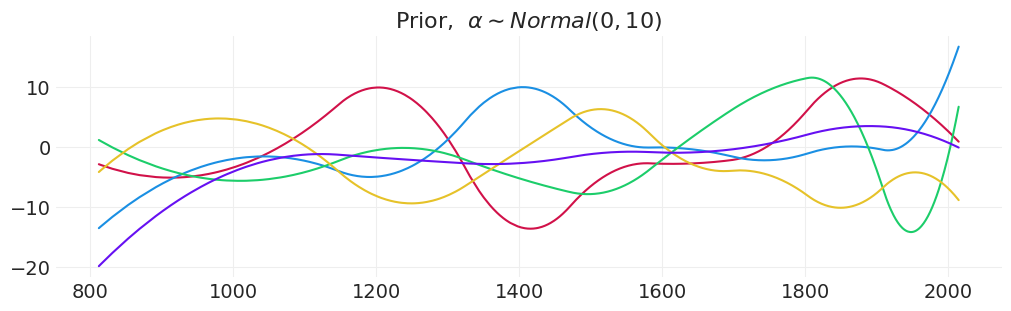

In [119]:
fig, ax = plt.subplots(figsize=(10, 3))
n_samples = 5
spline_prior_sigma = 10
spline_prior = stats.norm(0, spline_prior_sigma)
for s in range(n_samples):
    sample = 0
    for bi in range(blossom_basis.shape[1]):
        sample += spline_prior.rvs() * blossom_basis[:, bi]
    ax.plot(BLOSSOMS.year, sample)
plt.title("Prior,  $\\alpha \\sim Normal(0, 10)$");

In [151]:
def fit_spline_model(data, xdim, ydim, n_bases=10):
    basis_set = generate_spline_basis(data, xdim, n_bases=n_bases).base
    
    with pm.Model() as spline_model:
        # Priors
        sigma = pm.Exponential("sigma", 1)
        alpha = pm.Normal("alpha", data[ydim].mean(), data[ydim].std())
        beta = pm.Normal("beta", 0, 25, shape=n_bases)
        
        # Likelihood
        mu = pm.Deterministic("mu", alpha + pm.math.dot(basis_set, beta.T))
        pm.Normal(ydim, mu, sigma, observed=data[ydim].values)
        
        spline_idata = pm.sample(target_accept=.95)
        
    _, ax = plt.subplots(figsize=(10, 3))
    plt.scatter(x=data[xdim], y=data[ydim])
    az.plot_hdi(data[xdim], spline_idata.posterior.mu, color='k', hdi_prob=.89, fill_kwargs=dict(alpha=.3, label='Posterior Mean'))
    plt.legend(loc='lower right')
    plt.xlabel(xdim)
    plt.ylabel(ydim)
        
    return spline_model, spline_idata, basis_set
        

### Cherry Blossoms Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2078 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


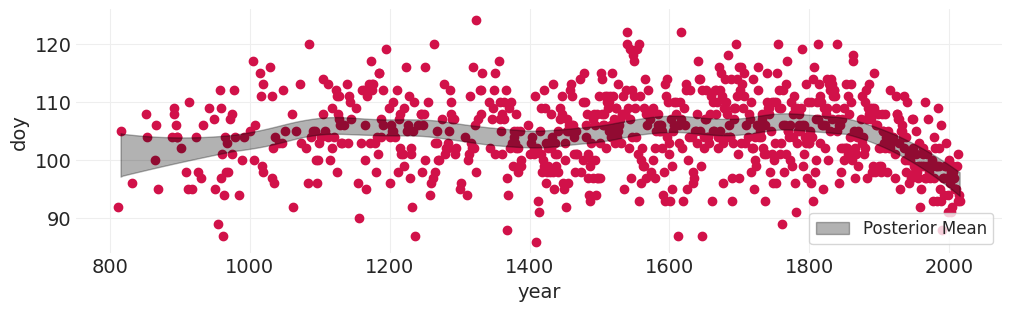

In [152]:
blossom_model, blossom_inference, blossom_basis = fit_spline_model(BLOSSOMS, 'year', 'doy', n_bases=20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,104.453,4.390,96.555,112.678,0.292,0.208,231.0,355.0,1.02
beta[0],-3.939,5.227,-13.991,5.313,0.297,0.210,313.0,604.0,1.02
beta[1],-2.231,4.963,-11.828,7.010,0.299,0.212,276.0,477.0,1.02
beta[2],-0.384,4.675,-8.934,8.337,0.289,0.205,265.0,439.0,1.02
beta[3],3.946,4.632,-4.894,12.577,0.292,0.207,254.0,364.0,1.02
beta[4],-2.668,4.598,-11.247,5.688,0.289,0.205,256.0,424.0,1.02
beta[5],4.261,4.693,-4.481,12.807,0.291,0.206,263.0,371.0,1.02
beta[6],-3.705,4.659,-12.422,5.080,0.294,0.211,257.0,463.0,1.02
beta[7],-1.555,4.622,-10.272,6.892,0.290,0.206,254.0,391.0,1.02
beta[8],1.962,4.587,-6.722,10.237,0.292,0.207,250.0,440.0,1.02


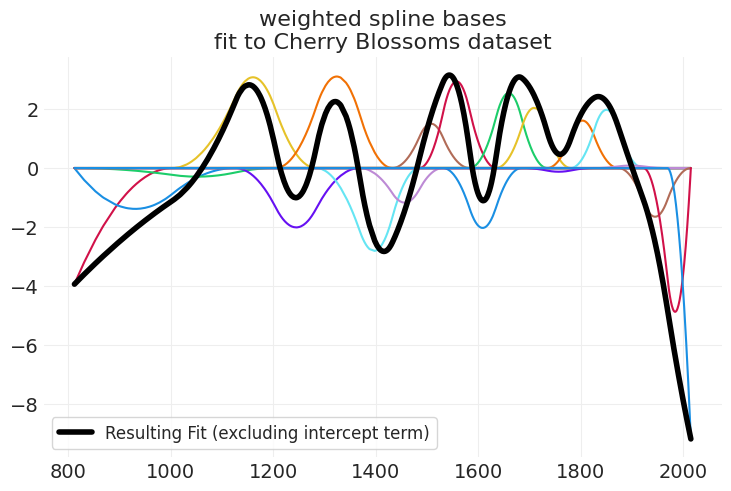

In [157]:
summary = az.summary(blossom_idata, var_names=['alpha', 'beta'])

beta_spline_mean = blossom_idata.posterior['beta'].mean(dim=('chain', 'draw')).values
resulting_fit = np.zeros_like(BLOSSOMS.year)
for bi, beta in enumerate(beta_spline_mean):
    weighted_basis = beta * blossom_basis[:, bi]
    plt.plot(BLOSSOMS.year, weighted_basis, color=f"C{bi}");
    resulting_fit = resulting_fit + weighted_basis
plt.plot(BLOSSOMS.year, resulting_fit, label='Resulting Fit (excluding intercept term)', color='k', linewidth=4)
plt.legend()
plt.title("weighted spline bases\nfit to Cherry Blossoms dataset");

summary

### Height as a function of age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


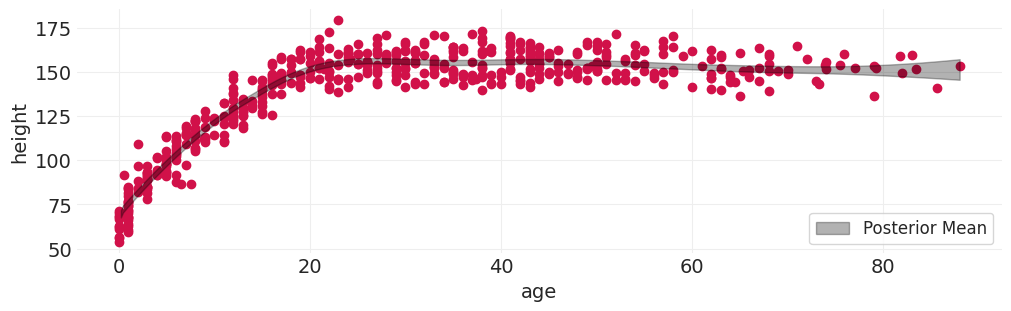

In [158]:
# Fit spline model to Howell height data
fit_spline_model(HOWELL, 'age', 'height', n_bases=10);

### Weight as a function of age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


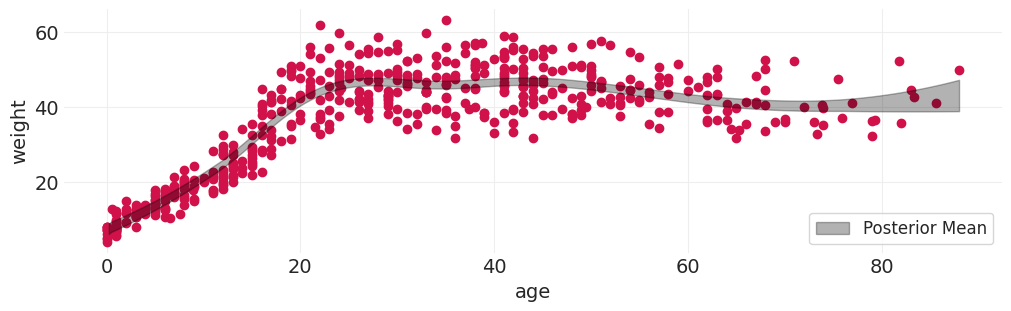

In [159]:
# While we're at it, let's fit spline model to Howell weight data
fit_spline_model(HOWELL, 'age', 'weight', n_bases=10);

# BONUS: Full Luxury Bayes
- Program the whole generative shebang into a single model
- Includes multiple submodels (likelihoods)

### Why would we do this?
- Can run simulations (interventions) from full generative model to look at causal estimates.

In [ ]:
utils.draw_causal_graph(
    edge_list=[
        ("H", "W"),
        ("S", "H"),
        ("S", "W")
    ],
    graph_direction="LR"
)

In [146]:
sex_indicator, sex = pd.factorize(["M" if s else "F" for s in ADULT_HOWELL["male"].values])
with pm.Model(coords={"sex": sex}) as flb_model:
    
    # Data
    S = pm.MutableData("S", sex_indicator, dims="obs_ids")
    H = pm.MutableData("H", ADULT_HOWELL.height.values, dims="obs_ids")
    Hbar = pm.MutableData("Hbar", ADULT_HOWELL.height.mean())
    
    # Height Model
    tau = pm.Uniform("tau", 0, 10)
    h = pm.Normal("h", 160, 10, dims='sex')
    nu = h[S]
    pm.Normal("H_obs", nu, tau, observed=ADULT_HOWELL.height.values, dims="obs_ids")
    
    # Weight Model
    alpha = pm.Normal("alpha", 60, 10, dims="sex")
    beta = pm.Uniform("beta", 0, 1, dims="sex")
    sigma = pm.Uniform("sigma", 0, 10)
    mu = alpha[S] + beta[S] * (H - Hbar)
    pm.Normal("W_obs", mu, sigma, observed=ADULT_HOWELL.weight.values, dims="obs_ids")
    
    flb_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, h, alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [147]:
summary = az.summary(flb_idata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h[M],160.354,0.421,159.598,161.172,0.006,0.004,5777.0,2928.0,1.0
h[F],149.537,0.408,148.774,150.299,0.005,0.004,5780.0,2776.0,1.0
alpha[M],45.075,0.449,44.280,45.975,0.007,0.005,4153.0,3221.0,1.0
alpha[F],45.172,0.436,44.308,45.964,0.007,0.005,4258.0,3011.0,1.0
tau,5.557,0.204,5.172,5.923,0.003,0.002,5518.0,3132.0,1.0
beta[M],0.613,0.054,0.511,0.714,0.001,0.001,4202.0,3104.0,1.0
beta[F],0.660,0.060,0.547,0.771,0.001,0.001,4159.0,2983.0,1.0
sigma,4.267,0.161,3.980,4.588,0.002,0.002,5538.0,2733.0,1.0


## Simulate interventions

In [148]:
def plot_posteror_mean_contrast(contrast_type='weight'):
    Hbar = ADULT_HOWELL.height.mean()
    means = az.summary(flb_idata)["mean"]
    
    H_F = stats.norm(means['h[F]'], means["tau"]).rvs(1000)
    H_M = stats.norm(means['h[M]'], means["tau"]).rvs(1000)
    
    W_F = stats.norm(means["beta[F]"] * (H_F - Hbar), means["sigma"]).rvs(1000)
    W_M = stats.norm(means["beta[M]"] * (H_M - Hbar), means["sigma"]).rvs(1000)
    contrast = H_M - H_F if contrast_type == 'height' else W_M - W_F
    
    az.plot_dist(contrast, color='k', plot_kwargs=dict(linewidth=3))
    plt.xlabel(f"Posterior mean {contrast_type} contrast")
    
    
def plot_causal_intervention_contrast(contrast_type):
    Hbar = ADULT_HOWELL.height.mean()
    
    # Causal Intervention
    F_posterior = flb_idata.posterior.sel(sex='F')
    M_posterior = flb_idata.posterior.sel(sex='M')
    
    H_F = stats.norm.rvs(F_posterior['h'], F_posterior['tau'])
    H_M = stats.norm.rvs(M_posterior['h'], M_posterior['tau'])
    
    W_F = stats.norm.rvs(F_posterior["beta"] * (H_F - Hbar), F_posterior["sigma"])
    W_M = stats.norm.rvs(M_posterior["beta"] * (H_M - Hbar), M_posterior["sigma"])
    
    contrast = H_M - H_F if contrast_type == 'height' else W_M - W_F
    
    pos_prob = 100 * np.sum(contrast >= 0) / np.product(contrast.shape)
    neg_prob = 100 - pos_prob
    
    kde_ax = az.plot_dist(contrast, color='k', plot_kwargs=dict(linewidth=3), bw=.5)
    
    # Shade under the posterior predictive contrast
    kde_x, kde_y = kde_ax.lines[0].get_data()
    
    # Proportion of PPD contrast below 0
    neg_idx = kde_x < 0
    plt.fill_between(
        x=kde_x[neg_idx],
        y1=np.zeros(sum(neg_idx)),
        y2=kde_y[neg_idx],
        color='C0',
        label=f"{neg_prob:1.0f}%"
    )
    
    # Proportion of PPD contrast above 0
    pos_idx = kde_x > 0
    plt.fill_between(
        x=kde_x[pos_idx],
        y1=np.zeros(sum(pos_idx)),
        y2=kde_y[pos_idx],
        color='C1',
        label=f"{pos_prob:1.0f}%"
    )
    
    plt.axvline(0, color='k')
    plt.legend(title="Proportion M>F")
    plt.xlabel(f"Posterior {contrast_type} contrast")
    

def plot_flb_contrast(contrast_type='weight', figsize=(8, 4)):
    _, axs = plt.subplots(1, 2, figsize=figsize)
    plt.sca(axs[0])
    plot_posteror_mean_contrast(contrast_type)
    
    plt.sca(axs[1])
    plot_causal_intervention_contrast(contrast_type)

/tmp/ipykernel_62729/4004137878.py:70: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  plot_causal_intervention_contrast(contrast_type)


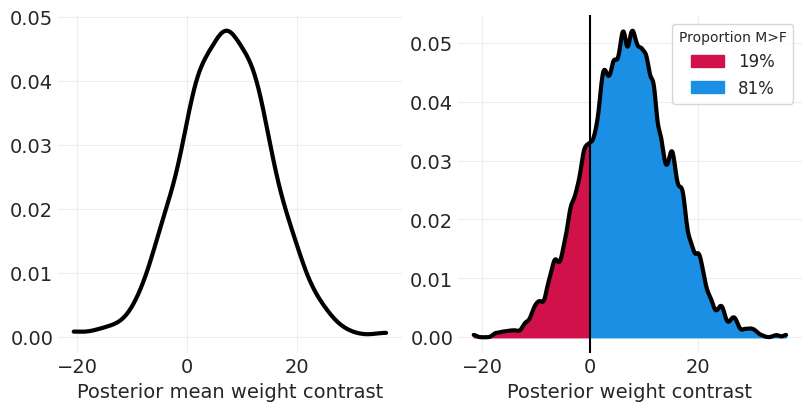

In [149]:
plot_flb_contrast('weight')

/tmp/ipykernel_62729/4004137878.py:70: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  plot_causal_intervention_contrast(contrast_type)


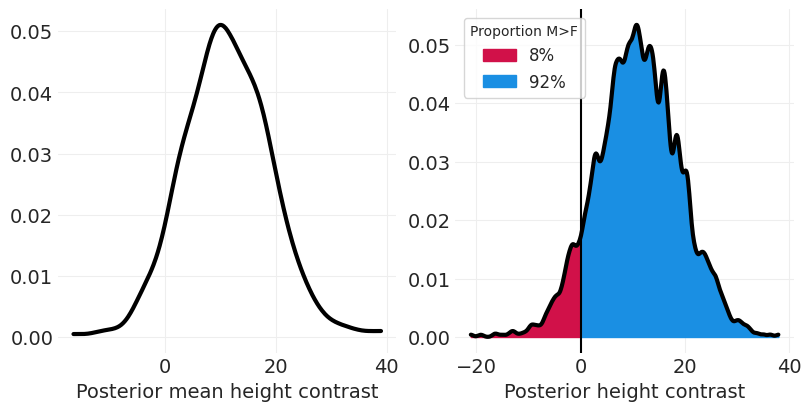

In [150]:
plot_flb_contrast('height')